# Задача класифікації з логістичною регресією в ScikitLearn

В цьому ноутбуці ми
- розвʼяжемо задачу бінарної класифікації
- побудуємо ПОВНЕ і ПОВНОЦІННЕ рішення задачі машинного навчання з усіма основними етапами
- натренуємо логістичну регресію і виміряємо її точніть
- збережемо результати моделі, а також дані
- дізнаємось про пайплайни і навчимось ними користатись

## Постановка задачі

В цьому уроці ми навчимося застосовувати _логістичну регресію_ до реального набору даних з [Kaggle](https://kaggle.com/datasets):

**НАША ЗАДАЧА**: [Набір даних про дощі в Австралії](https://kaggle.com/jsphyg/weather-dataset-rattle-package) містить приблизно 10 років щоденних спостережень за погодою з численних австралійських метеостанцій. Ось невеликий зразок з набору даних:

![](https://i.imgur.com/5QNJvir.png)

Як Data Scientist у Бюро метеорології, вам доручено створити повністю автоматизовану систему, яка може використовувати дані про погоду на сьогодні для певного місця, щоб передбачити, чи буде дощ у цьому місці завтра.

![](https://i.imgur.com/KWfcpcO.png)


### Робочий процес машинного навчання

Незалежно від того, чи вирішуємо ми задачу регресії за допомогою лінійної регресії, чи задачу класифікації за допомогою логістичної регресії, робочий процес для навчання моделі є однаковим:

1. Ми ініціалізуємо модель з випадковими параметрами (вагами та зміщеннями).
2. Ми передаємо деякі вхідні дані в модель, щоб отримати прогнози.
3. Ми порівнюємо прогнози моделі з фактичними цільовими значеннями за допомогою функції втрат.
4. Ми використовуємо метод оптимізації (такий як метод найменших квадратів, градієнтний спуск тощо) для зменшення втрат шляхом коригування ваг та зміщень моделі.
5. Ми повторюємо кроки з 1 по 4, поки прогнози моделі не стануть достатньо точними.


<img src="https://i.imgur.com/g32CoIy.png" width="480">


## Завантаження даних

Ми будемо використовувати бібліотеку [`opendatasets`](https://github.com/JovianML/opendatasets) для завантаження даних з Kaggle безпосередньо в Jupyter. Давайте встановимо та імпортуємо `opendatasets`.

In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
import opendatasets as od

In [ ]:
od.version()

'0.1.22'

Тепер набір даних можна завантажити за допомогою `od.download`. Коли ви виконаєте `od.download`, вас попросять вказати ваше ім'я користувача Kaggle та API ключ. Дотримуйтесь цих інструкцій, щоб створити API ключ: http://bit.ly/kaggle-creds

In [ ]:
dataset_url = 'https://www.kaggle.com/jsphyg/weather-dataset-rattle-package'

In [ ]:
od.download(dataset_url)

Після виконання вищезазначеної команди, набір даних буде завантажено та розпаковано в директорію `weather-dataset-rattle-package`.

In [ ]:
import os

In [ ]:
data_dir = './weather-dataset-rattle-package'

In [ ]:
os.listdir(data_dir)

In [ ]:
train_csv = data_dir + '/weatherAUS.csv'

Давайте завантажимо дані з `weatherAUS.csv` за допомогою Pandas.

In [ ]:
import pandas as pd

In [ ]:
# оберіть опцію, яка вам зручніша
# raw_df = pd.read_csv(train_csv)
raw_df = pd.read_csv('weatherAUS.csv')

In [ ]:
raw_df

Набір даних містить понад 145,000 рядків і 23 стовпці. Набір даних містить стовпці з датами, числовими та категоріальними значеннями. Наша мета - створити модель для прогнозування значення в стовпці `RainTomorrow`.

Давайте перевіримо типи даних та відсутні значення в різних стовпцях.

In [ ]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

Хоча ми повинні мати можливість заповнити відсутні значення для більшості стовпців, можливо, варто відкинути рядки, де значення `RainTomorrow` або `RainToday` відсутні, щоб зробити наш аналіз і моделювання простішими (оскільки одне з них є цільовою змінною, а інше, ймовірно, дуже тісно пов'язане з цільовою змінною).

In [ ]:
raw_df.dropna(subset=['RainToday', 'RainTomorrow'], inplace=True)

In [ ]:
raw_df.shape

(140787, 23)

Як би ви впоралися з відсутніми значеннями в інших стовпцях?

## (Опціонально) Робота з вибіркою

Коли ви працюєте з великими наборами даних, що містять мільйони рядків, спочатку варто працювати з вибіркою, щоб швидко налаштувати свій блокнот для навчання моделі. Якщо ви хочете працювати з вибіркою, просто встановіть значення `use_sample` на `True`.

In [ ]:
use_sample = False

In [ ]:
sample_fraction = 0.1

In [ ]:
if use_sample:
    raw_df = raw_df.sample(frac=sample_fraction).copy()

Переконайтеся, що `use_sample` встановлено на `False`, і повторно запустіть ноутбук від початку до кінця, коли будете готові використовувати весь набір даних.

## Навчальна, валідаційна та тестова вибірки

В попередньому уроці ми дізнались, що в машинному навчанні варто розділяти вибірку на підвибірки: train, validation, test.

1. **Навчальна вибірка** - використовується для навчання моделі, тобто для обчислення втрат і налаштування ваг моделі за допомогою оптимізаційної техніки.


2. **Валідаційна вибірка** - використовується для оцінки моделі під час навчання, налаштування гіперпараметрів моделі (оптимізаційна техніка, регуляризація тощо) та вибору найкращої версії моделі. Вибір хорошої валідаційної вибірки є важливим для навчання моделей, які добре узагальнюють. [Дізнайтеся більше тут.](https://www.fast.ai/2017/11/13/validation-sets/)


3. **Тестова вибірка** - використовується для порівняння різних моделей або підходів і звітування про кінцеву точність моделі. Для багатьох наборів даних тестові вибірки надаються окремо. Тестова вибірка повинна максимально точно відображати тип даних, з якими модель зіткнеться в реальному світі.


<img src="https://i.imgur.com/j8eITrK.png" width="480">


Як загальне правило, рекомендується використовувати близько 60% даних для навчальної вибірки, 20% для валідаційної вибірки та 20% для тестової вибірки. Якщо окрема тестова вибірка вже надана, ви можете використовувати розподіл 75%-25% для навчання та валідації.

Давайте зробимо розбиття нашої вибірки.

Коли рядки в наборі даних не мають внутрішнього порядку, звичайною практикою є вибір **випадкових** підмножин рядків для створення тестових і валідаційних вибірок.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_val_df, test_df = train_test_split(raw_df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.25, random_state=42)

In [ ]:
print('train_df.shape :', train_df.shape)
print('val_df.shape :', val_df.shape)
print('test_df.shape :', test_df.shape)

train_df.shape : (84471, 23)
val_df.shape : (28158, 23)
test_df.shape : (28158, 23)


Однак, під час роботи з датами часто краще розділяти навчальні, валідаційні та тестові набори за часом, щоб модель навчалася на даних з минулого і оцінювалася на даних з майбутнього.

Для поточного набору даних ми можемо використати стовпець Date у наборі даних, щоб створити інший стовпець для року. Ми виберемо останні два роки для тестового набору і один рік перед ними для валідаційного набору.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

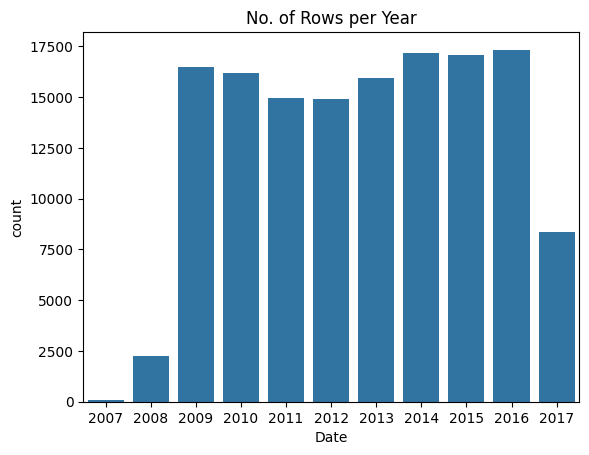

In [ ]:
plt.title('No. of Rows per Year')
sns.countplot(x=pd.to_datetime(raw_df.Date).dt.year);

In [ ]:
year = pd.to_datetime(raw_df.Date).dt.year

train_df = raw_df[year < 2015]
val_df = raw_df[year == 2015]
test_df = raw_df[year > 2015]

In [ ]:
print('train_df.shape :', train_df.shape)
print('val_df.shape :', val_df.shape)
print('test_df.shape :', test_df.shape)

train_df.shape : (97988, 23)
val_df.shape : (17089, 23)
test_df.shape : (25710, 23)


Хоча це не ідеальний розподіл 60-20-20, ми забезпечили, щоб набори даних для тестування та валідації містили дані за всі 12 місяців року.

## Визначення вхідних та цільових стовпців

Часто не всі стовпці в наборі даних корисні для навчання моделі. У поточному наборі даних ми можемо ігнорувати стовпець `Date`, оскільки ми хочемо використовувати лише погодні умови для прогнозування, чи буде дощ наступного дня. В загальному випадку дату ми можемо використовувати і генерувати з неї багато ознак, наприклад, місяць, сезон, чи є день буднім і тд.

Давайте створимо список вхідних стовпців, а також визначимо цільовий стовпець.

In [ ]:
input_cols = list(train_df.columns)[1:-1]
target_col = 'RainTomorrow'

In [ ]:
print(input_cols)

['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday']


In [ ]:
target_col

'RainTomorrow'

Тепер ми можемо створити вхідні дані та цільові значення для навчальних, валідаційних та тестових наборів для подальшої обробки та навчання моделі.

In [ ]:
train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()

In [ ]:
val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()

In [ ]:
test_inputs = test_df[input_cols].copy()
test_targets = test_df[target_col].copy()

Давайте також визначимо, які з колонок є числовими, а які категоріальними. Це буде корисно пізніше, оскільки нам потрібно буде перетворити категоріальні дані на числа для навчання моделі логістичної регресії.

In [ ]:
import numpy as np

In [ ]:
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

In [ ]:
numeric_cols, categorical_cols

(['MinTemp',
  'MaxTemp',
  'Rainfall',
  'Evaporation',
  'Sunshine',
  'WindGustSpeed',
  'WindSpeed9am',
  'WindSpeed3pm',
  'Humidity9am',
  'Humidity3pm',
  'Pressure9am',
  'Pressure3pm',
  'Cloud9am',
  'Cloud3pm',
  'Temp9am',
  'Temp3pm'],
 ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday'])

Давайте переглянемо деяку статистику для числових стовпців.

In [ ]:
train_inputs[numeric_cols].describe().round(2)

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,97674.00,97801.00,97988.00,61657.00,57942.00,91160.00,97114.00,96919.00,96936.00,96872.00,88876.00,88857.00,63000.00,61966.00,97414.00,97392.00
mean,12.01,23.02,2.37,5.29,7.61,40.22,14.09,18.76,68.63,51.47,1017.51,1015.13,4.30,4.41,16.84,21.54
std,6.35,6.98,8.52,3.95,3.79,13.70,8.98,8.87,19.00,20.76,7.07,7.00,2.87,2.69,6.40,6.83
min,-8.50,-4.10,0.00,0.00,0.00,6.00,0.00,0.00,0.00,0.00,980.50,979.00,0.00,0.00,-5.90,-5.10
25%,7.50,17.90,0.00,2.60,4.80,31.00,7.00,13.00,57.00,37.00,1012.80,1010.40,1.00,2.00,12.20,16.60
50%,11.80,22.40,0.00,4.60,8.50,39.00,13.00,19.00,70.00,52.00,1017.50,1015.10,5.00,5.00,16.60,20.90
75%,16.60,27.90,0.80,7.20,10.60,48.00,19.00,24.00,83.00,66.00,1022.30,1019.90,7.00,7.00,21.40,26.20
max,33.90,48.10,371.00,82.40,14.30,135.00,87.00,87.00,100.00,100.00,1041.00,1039.60,9.00,9.00,40.20,46.10


Чи здаються діапазони числових стовпців розумними? Якщо ні, можливо, нам доведеться також провести очищення даних.

Давайте також перевіримо кількість категорій у кожному з категоріальних стовпців.

In [ ]:
train_inputs[categorical_cols].nunique()

,0
Location,49
WindGustDir,16
WindDir9am,16
WindDir3pm,16
RainToday,2


## Заповнення відсутніх числових даних

Багато моделей машинного навчання не можуть працювати з відсутніми числовими даними. Процес заповнення відсутніх значень називається імпутацією.

<img src="https://i.imgur.com/W7cfyOp.png" width="480">

Існує кілька технік імпутації, але ми використаємо найпростішу: заміну відсутніх значень на середнє значення в стовпці за допомогою класу `SimpleImputer` з `sklearn.impute`.

In [ ]:
from sklearn.impute import SimpleImputer

In [ ]:
?SimpleImputer

In [ ]:
imputer = SimpleImputer(strategy = 'mean')

Перш ніж виконувати імпутацію, давайте перевіримо кількість відсутніх значень у кожному числовому стовпці.

In [ ]:
raw_df.shape

(140787, 23)

In [ ]:
raw_df[numeric_cols].isna().sum()

,0
MinTemp,468
MaxTemp,307
Rainfall,0
Evaporation,59694
Sunshine,66805
WindGustSpeed,9105
WindSpeed9am,1055
WindSpeed3pm,2531
Humidity9am,1517
Humidity3pm,3501


Ці значення розподілені між навчальним, тестовим та валідаційним наборами. Ви також можете перевірити кількість відсутніх значень окремо для `train_inputs`, `val_inputs` та `test_inputs`.

In [ ]:
train_inputs[numeric_cols].isna().sum()

,0
MinTemp,314
MaxTemp,187
Rainfall,0
Evaporation,36331
Sunshine,40046
WindGustSpeed,6828
WindSpeed9am,874
WindSpeed3pm,1069
Humidity9am,1052
Humidity3pm,1116


Першим кроком в імпутації є `fit` імпутера до даних, тобто обчислення обраної статистики (наприклад, середнього) для кожного стовпця в наборі даних.

In [ ]:
imputer.fit(train_inputs[numeric_cols])

SimpleImputer()

Після виклику `fit`, обчислена статистика для кожного стовпця зберігається у властивості `statistics_` об'єкта `imputer`.

In [ ]:
list(imputer.statistics_)

[12.0078311526097,
 23.0222022269711,
 2.37293546148508,
 5.289991404057933,
 7.609003831417626,
 40.21587318999561,
 14.09226270156723,
 18.76460755888938,
 68.62874473879673,
 51.46954744404988,
 1017.5137337413925,
 1015.132351891241,
 4.302952380952381,
 4.410676822773779,
 16.835126367873205,
 21.54013779365862]

Тепер відсутні значення в наборах даних для тренування, тестування та валідації можна заповнити за допомогою методу `transform` об'єкта `imputer`.

In [ ]:
train_inputs[numeric_cols] = imputer.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = imputer.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = imputer.transform(test_inputs[numeric_cols])

Відсутні значення тепер заповнені середнім значенням кожного стовпця.

In [ ]:
train_inputs[numeric_cols].isna().sum()

,0
MinTemp,0
MaxTemp,0
Rainfall,0
Evaporation,0
Sunshine,0
WindGustSpeed,0
WindSpeed9am,0
WindSpeed3pm,0
Humidity9am,0
Humidity3pm,0


Ви можете дізнатися більше про інші методи імпутації тут: https://scikit-learn.org/stable/modules/impute.html

Метод імпутації - це частина експерименту, адже результат моделі може змінитись від способа імпутації даних. Тому ми змінюючи імпутацію можемо спостерігати, як це впливає на модель.

## Масштабування числових ознак

Ми памʼятаємо з вами про масштабування ознак з минулої лекції. Масштабування числових ознак забезпечує, що жодна конкретна ознака не має непропорційного впливу на втрати моделі. Оптимізаційні алгоритми також працюють краще на практиці з меншими числами.

Числові стовпці в нашому наборі даних мають різні діапазони.

In [ ]:
raw_df[numeric_cols].describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,140319.000000,140480.00000,140787.000000,81093.000000,73982.000000,131682.000000,139732.000000,138256.000000,139270.000000,137286.000000,127044.000000,127018.000000,88162.000000,84693.000000,140131.000000,138163.000000
mean,12.184824,23.23512,2.349974,5.472516,7.630540,39.970520,13.990496,18.631141,68.826833,51.449288,1017.654577,1015.257963,4.431161,4.499250,16.987066,21.693183
std,6.403879,7.11450,8.465173,4.189132,3.781729,13.578201,8.886210,8.798096,19.063650,20.807310,7.104867,7.035411,2.886594,2.719752,6.496012,6.937784
min,-8.500000,-4.80000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-7.200000,-5.400000
25%,7.600000,17.90000,0.000000,2.600000,4.900000,31.000000,7.000000,13.000000,57.000000,37.000000,1013.000000,1010.400000,1.000000,2.000000,12.300000,16.600000
50%,12.000000,22.60000,0.000000,4.800000,8.500000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.600000,1015.200000,5.000000,5.000000,16.700000,21.100000
75%,16.800000,28.30000,0.800000,7.400000,10.700000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.400000,1020.000000,7.000000,7.000000,21.600000,26.400000
max,33.900000,48.10000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,9.000000,9.000000,40.200000,46.700000


Давайте використаємо `MinMaxScaler` з `sklearn.preprocessing`, щоб масштабувати значення до діапазону $(0,1)$.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
?MinMaxScaler

In [ ]:
scaler = MinMaxScaler()

Спочатку ми `підганяємо` масштабувальник до даних, тобто обчислюємо діапазон значень для кожного числового стовпця.

In [ ]:
scaler.fit(train_inputs[numeric_cols])

MinMaxScaler()

Тепер ми можемо окремо масштабувати навчальні, валідаційні та тестові набори, використовуючи метод `transform` класу `scaler`.

In [ ]:
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

Тепер ми можемо перевірити, що значення в кожному стовпці лежать у діапазоні $(0,1)$

In [ ]:
train_inputs[numeric_cols].describe().round(2)

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,97988.00,97988.00,97988.00,97988.00,97988.00,97988.00,97988.00,97988.00,97988.00,97988.00,97988.00,97988.00,97988.00,97988.00,97988.00,97988.00
mean,0.48,0.52,0.01,0.06,0.53,0.27,0.16,0.22,0.69,0.51,0.61,0.60,0.48,0.49,0.49,0.52
std,0.15,0.13,0.02,0.04,0.20,0.10,0.10,0.10,0.19,0.21,0.11,0.11,0.26,0.24,0.14,0.13
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.38,0.42,0.00,0.05,0.52,0.19,0.08,0.15,0.57,0.37,0.54,0.53,0.33,0.33,0.39,0.42
50%,0.48,0.51,0.00,0.06,0.53,0.26,0.15,0.22,0.69,0.52,0.61,0.60,0.48,0.49,0.49,0.51
75%,0.59,0.61,0.00,0.07,0.64,0.31,0.22,0.28,0.83,0.65,0.68,0.67,0.67,0.67,0.59,0.61
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


## Кодування категоріальних даних

Оскільки моделі машинного навчання можуть бути навчені лише з числовими даними, нам потрібно перетворити категоріальні дані на числа. Поширеною технікою є використання one-hot кодування для категоріальних стовпців.

<img src="https://i.imgur.com/n8GuiOO.png" width="640">

One-hot кодування передбачає додавання нового бінарного (0/1) стовпця для кожної унікальної категорії категоріального стовпця.

In [ ]:
raw_df[categorical_cols].nunique()

,0
Location,49
WindGustDir,16
WindDir9am,16
WindDir3pm,16
RainToday,2


Ми можемо виконати one hot кодування за допомогою класу `OneHotEncoder` з `sklearn.preprocessing`.

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
?OneHotEncoder

In [ ]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

Спочатку ми `fit` енкодер до даних, тобто визначаємо повний список категорій у всіх категоріальних стовпцях.

In [ ]:
encoder.fit(train_inputs[categorical_cols])

OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [ ]:
encoder.categories_

[array(['Adelaide', 'Albany', 'Albury', 'AliceSprings', 'BadgerysCreek',
        'Ballarat', 'Bendigo', 'Brisbane', 'Cairns', 'Canberra', 'Cobar',
        'CoffsHarbour', 'Dartmoor', 'Darwin', 'GoldCoast', 'Hobart',
        'Katherine', 'Launceston', 'Melbourne', 'MelbourneAirport',
        'Mildura', 'Moree', 'MountGambier', 'MountGinini', 'Newcastle',
        'Nhil', 'NorahHead', 'NorfolkIsland', 'Nuriootpa', 'PearceRAAF',
        'Penrith', 'Perth', 'PerthAirport', 'Portland', 'Richmond', 'Sale',
        'SalmonGums', 'Sydney', 'SydneyAirport', 'Townsville',
        'Tuggeranong', 'Uluru', 'WaggaWagga', 'Walpole', 'Watsonia',
        'Williamtown', 'Witchcliffe', 'Wollongong', 'Woomera'],
       dtype=object),
 array(['E', 'ENE', 'ESE', 'N', 'NE', 'NNE', 'NNW', 'NW', 'S', 'SE', 'SSE',
        'SSW', 'SW', 'W', 'WNW', 'WSW', nan], dtype=object),
 array(['E', 'ENE', 'ESE', 'N', 'NE', 'NNE', 'NNW', 'NW', 'S', 'SE', 'SSE',
        'SSW', 'SW', 'W', 'WNW', 'WSW', nan], dtype=object),
 ar

Енкодер створив список категорій для кожного з категоріальних стовпців у наборі даних.

Ми можемо згенерувати назви стовпців для кожної окремої категорії, використовуючи `get_feature_names_out`.

In [ ]:
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
print(encoded_cols)

['Location_Adelaide', 'Location_Albany', 'Location_Albury', 'Location_AliceSprings', 'Location_BadgerysCreek', 'Location_Ballarat', 'Location_Bendigo', 'Location_Brisbane', 'Location_Cairns', 'Location_Canberra', 'Location_Cobar', 'Location_CoffsHarbour', 'Location_Dartmoor', 'Location_Darwin', 'Location_GoldCoast', 'Location_Hobart', 'Location_Katherine', 'Location_Launceston', 'Location_Melbourne', 'Location_MelbourneAirport', 'Location_Mildura', 'Location_Moree', 'Location_MountGambier', 'Location_MountGinini', 'Location_Newcastle', 'Location_Nhil', 'Location_NorahHead', 'Location_NorfolkIsland', 'Location_Nuriootpa', 'Location_PearceRAAF', 'Location_Penrith', 'Location_Perth', 'Location_PerthAirport', 'Location_Portland', 'Location_Richmond', 'Location_Sale', 'Location_SalmonGums', 'Location_Sydney', 'Location_SydneyAirport', 'Location_Townsville', 'Location_Tuggeranong', 'Location_Uluru', 'Location_WaggaWagga', 'Location_Walpole', 'Location_Watsonia', 'Location_Williamtown', 'Loca

Усі вищезазначені стовпці будуть додані до `train_inputs`, `val_inputs` та `test_inputs`.

Для виконання кодування ми використовуємо метод `transform` об'єкта `encoder`.

In [ ]:
encoder.transform(train_inputs[categorical_cols])[:10]

array([[0., 0., 1., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 1., 0.],
       ...,
       [0., 0., 1., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 1.]])

In [ ]:
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

<ipython-input-61-8950d7c1751d>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
<ipython-input-61-8950d7c1751d>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
<ipython-input-61-8950d7c1751d>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at 

Ми можемо перевірити, що ці нові стовпці були додані до наших навчальних, тестових та валідаційних наборів.

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
test_inputs

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,Location_Adelaide,Location_Albany,Location_Albury,Location_AliceSprings,Location_BadgerysCreek,Location_Ballarat,Location_Bendigo,Location_Brisbane,Location_Cairns,Location_Canberra,Location_Cobar,Location_CoffsHarbour,Location_Dartmoor,Location_Darwin,Location_GoldCoast,Location_Hobart,Location_Katherine,Location_Launceston,Location_Melbourne,Location_MelbourneAirport,Location_Mildura,Location_Moree,Location_MountGambier,Location_MountGinini,Location_Newcastle,Location_Nhil,Location_NorahHead,Location_NorfolkIsland,Location_Nuriootpa,Location_PearceRAAF,Location_Penrith,Location_Perth,Location_PerthAirport,Location_Portland,Location_Richmond,Location_Sale,Location_SalmonGums,Location_Sydney,Location_SydneyAirport,Location_Townsville,Location_Tuggeranong,Location_Uluru,Location_WaggaWagga,Location_Walpole,Location_Watsonia,Location_Williamtown,Location_Witchcliffe,Location_Wollongong,Location_Woomera,WindGustDir_E,WindGustDir_ENE,WindGustDir_ESE,WindGustDir_N,WindGustDir_NE,WindGustDir_NNE,WindGustDir_NNW,WindGustDir_NW,WindGustDir_S,WindGustDir_SE,WindGustDir_SSE,WindGustDir_SSW,WindGustDir_SW,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW,WindGustDir_nan,WindDir9am_E,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW,WindDir9am_nan,WindDir3pm_E,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,WindDir3pm_nan,RainToday_No,RainToday_Yes
2498,Albury,0.681604,0.798851,0.000000,0.064199,0.532098,ENE,0.372093,NaN,ESE,0.000000,0.080460,0.46,0.17,0.543802,0.498350,0.777778,0.333333,0.694143,0.816406,No,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2499,Albury,0.693396,0.722222,0.001078,0.064199,0.532098,SSE,0.341085,SSE,SE,0.103448,0.195402,0.54,0.30,0.505785,0.485149,0.888889,0.888889,0.665944,0.718750,No,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2500,Albury,0.634434,0.521073,0.005930,0.064199,0.532098,ENE,0.325581,ESE,ENE,0.126437,0.448276,0.62,0.67,0.553719,0.590759,0.888889,0.888889,0.600868,0.480469,Yes,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2501,Albury,0.608491,0.532567,0.042049,0.064199,0.532098,SSE,0.255814,SE,SSE,0.103448,0.195402,0.74,0.65,0.618182,0.618812,0.888889,0.888889,0.544469,0.521484,Yes,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

## Збереження оброблених даних на диск

Може бути корисним зберігати оброблені дані на диск, особливо для дуже великих наборів даних, щоб уникнути повторення кроків попередньої обробки щоразу, коли ви запускаєте Jupyter notebook. Формат parquet є швидким та ефективним форматом для збереження та завантаження dataframes Pandas. Дані зберігаються і читаються швидше, ніж з csv, а також менше важать!

Більше про паркет і формати збереження даних [тут](https://towardsdatascience.com/demystifying-the-parquet-file-format-13adb0206705)

In [ ]:
print('train_inputs:', train_inputs.shape)
print('train_targets:', train_targets.shape)
print('val_inputs:', val_inputs.shape)
print('val_targets:', val_targets.shape)
print('test_inputs:', test_inputs.shape)
print('test_targets:', test_targets.shape)

train_inputs: (97988, 123)
train_targets: (97988,)
val_inputs: (17089, 123)
val_targets: (17089,)
test_inputs: (25710, 123)
test_targets: (25710,)


In [ ]:
!pip install pyarrow --quiet

In [ ]:
train_inputs.to_parquet('train_inputs.parquet')
val_inputs.to_parquet('val_inputs.parquet')
test_inputs.to_parquet('test_inputs.parquet')

In [ ]:
%%time
pd.DataFrame(train_targets).to_parquet('train_targets.parquet')
pd.DataFrame(val_targets).to_parquet('val_targets.parquet')
pd.DataFrame(test_targets).to_parquet('test_targets.parquet')

CPU times: user 59.3 ms, sys: 8.68 ms, total: 67.9 ms
Wall time: 179 ms


Ми можемо зчитати дані назад, використовуючи `pd.read_parquet`.

In [ ]:
%%time

train_inputs = pd.read_parquet('train_inputs.parquet')
val_inputs = pd.read_parquet('val_inputs.parquet')
test_inputs = pd.read_parquet('test_inputs.parquet')

train_targets = pd.read_parquet('train_targets.parquet')[target_col]
val_targets = pd.read_parquet('val_targets.parquet')[target_col]
test_targets = pd.read_parquet('test_targets.parquet')[target_col]

CPU times: user 347 ms, sys: 208 ms, total: 554 ms
Wall time: 786 ms


Давайте перевіримо, чи дані були завантажені правильно.

In [ ]:
print('train_inputs:', train_inputs.shape)
print('train_targets:', train_targets.shape)
print('val_inputs:', val_inputs.shape)
print('val_targets:', val_targets.shape)
print('test_inputs:', test_inputs.shape)
print('test_targets:', test_targets.shape)

train_inputs: (97988, 123)
train_targets: (97988,)
val_inputs: (17089, 123)
val_targets: (17089,)
test_inputs: (25710, 123)
test_targets: (25710,)


In [ ]:
val_inputs

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,Location_Adelaide,Location_Albany,Location_Albury,Location_AliceSprings,Location_BadgerysCreek,Location_Ballarat,Location_Bendigo,Location_Brisbane,Location_Cairns,Location_Canberra,Location_Cobar,Location_CoffsHarbour,Location_Dartmoor,Location_Darwin,Location_GoldCoast,Location_Hobart,Location_Katherine,Location_Launceston,Location_Melbourne,Location_MelbourneAirport,Location_Mildura,Location_Moree,Location_MountGambier,Location_MountGinini,Location_Newcastle,Location_Nhil,Location_NorahHead,Location_NorfolkIsland,Location_Nuriootpa,Location_PearceRAAF,Location_Penrith,Location_Perth,Location_PerthAirport,Location_Portland,Location_Richmond,Location_Sale,Location_SalmonGums,Location_Sydney,Location_SydneyAirport,Location_Townsville,Location_Tuggeranong,Location_Uluru,Location_WaggaWagga,Location_Walpole,Location_Watsonia,Location_Williamtown,Location_Witchcliffe,Location_Wollongong,Location_Woomera,WindGustDir_E,WindGustDir_ENE,WindGustDir_ESE,WindGustDir_N,WindGustDir_NE,WindGustDir_NNE,WindGustDir_NNW,WindGustDir_NW,WindGustDir_S,WindGustDir_SE,WindGustDir_SSE,WindGustDir_SSW,WindGustDir_SW,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW,WindGustDir_nan,WindDir9am_E,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW,WindDir9am_nan,WindDir3pm_E,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,WindDir3pm_nan,RainToday_No,RainToday_Yes
2133,Albury,0.469340,0.720307,0.0,0.064199,0.532098,WSW,0.186047,ESE,W,0.080460,0.126437,0.45,0.14,0.545455,0.528053,0.478106,0.490075,0.583514,0.738281,No,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2134,Albury,0.566038,0.837165,0.0,0.064199,0.532098,NE,0.387597,ESE,ESE,0.103448,0.103448,0.45,0.12,0.586777,0.551155,0.478106,0.490075,0.683297,0.845703,No,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2135,Albury,0.603774,0.812261,0.0,0.064199,0.532098,NNE,0.325581,NE,N,0.229885,0.229885,0.35,0.19,0.618182,0.549505,0.478106,0.490075,0.761388,0.822266,No,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2136,Albury,0.813679,0.712644,0.0,0.064199,0.532098,NNE,0.271318,ESE,W,0.080460,0.080460,0.46,0.37,0.547107,0.546205,0.888889,0.555556,0.722343,0.703125,No,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0

In [ ]:
val_targets

,RainTomorrow
2133,No
2134,No
2135,No
2136,No
2137,No
...,...
144913,No
144914,No
144915,No
144916,No


## Навчання моделі логістичної регресії

Логістична регресія є загальновживаною технікою для розв'язання задач бінарної класифікації. У моделі логістичної регресії:

- ми беремо лінійну комбінацію (або зважену суму вхідних ознак)
- ми застосовуємо сигмоїдну функцію до результату, щоб отримати число між 0 і 1
- це число представляє ймовірність того, що вхідні дані будуть класифіковані як "Так"
- замість RMSE використовується функція втрат крос-ентропії для оцінки результатів

Ось візуальне резюме того, як структурована модель логістичної регресії:

<img src="https://i.imgur.com/YMaMo5D.png" width="480">

Сигмоїдна функція, застосована до лінійної комбінації вхідних даних, має наступну формулу:

<img src="https://i.imgur.com/sAVwvZP.png" width="400">

Для навчання моделі логістичної регресії ми можемо використовувати клас `LogisticRegression` з бібліотеки Scikit-learn.

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
model = LogisticRegression(solver='liblinear')

Ми можемо тренувати модель за допомогою `model.fit`.

In [ ]:
?model.fit

In [ ]:
model.fit(train_inputs[numeric_cols + encoded_cols], train_targets)

LogisticRegression(solver='liblinear')

`model.fit` використовує наступний робочий процес для навчання моделі ([джерело](https://www.deepnetts.com/blog/from-basic-machine-learning-to-deep-learning-in-5-minutes.html)):

1. Ми ініціалізуємо модель з випадковими параметрами (вагами та зміщеннями).
2. Ми передаємо деякі вхідні дані в модель, щоб отримати прогнози.
3. Ми порівнюємо прогнози моделі з фактичними цілями за допомогою функції втрат.
4. Ми використовуємо метод оптимізації (наприклад, метод найменших квадратів, градієнтний спуск тощо), щоб зменшити втрати, коригуючи ваги та зміщення моделі.
5. Ми повторюємо кроки з 1 по 4, поки прогнози моделі не стануть достатньо точними.

<img src="https://i.imgur.com/g32CoIy.png" width="480">

Логістичну регресію також можна застосувати до багатокласових задач класифікації з деякими модифікаціями. Про це - далі.

Давайте перевіримо ваги та зміщення навченої моделі.

In [ ]:
print(numeric_cols + encoded_cols)

['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'Location_Adelaide', 'Location_Albany', 'Location_Albury', 'Location_AliceSprings', 'Location_BadgerysCreek', 'Location_Ballarat', 'Location_Bendigo', 'Location_Brisbane', 'Location_Cairns', 'Location_Canberra', 'Location_Cobar', 'Location_CoffsHarbour', 'Location_Dartmoor', 'Location_Darwin', 'Location_GoldCoast', 'Location_Hobart', 'Location_Katherine', 'Location_Launceston', 'Location_Melbourne', 'Location_MelbourneAirport', 'Location_Mildura', 'Location_Moree', 'Location_MountGambier', 'Location_MountGinini', 'Location_Newcastle', 'Location_Nhil', 'Location_NorahHead', 'Location_NorfolkIsland', 'Location_Nuriootpa', 'Location_PearceRAAF', 'Location_Penrith', 'Location_Perth', 'Location_PerthAirport', 'Location_Portland', 'Location_Richmond', 'Location_Sale', 'Location_

In [ ]:
model.coef_.round(2)

array([[ 0.89, -2.85,  3.16,  0.64, -1.65,  6.76, -0.65, -1.42,  0.33,
         5.99,  5.53, -8.97, -0.16,  1.29,  0.47,  1.97,  0.61, -0.56,
         0.47, -0.  ,  0.35, -0.36,  0.17,  0.43, -0.02,  0.02,  0.25,
        -0.02, -0.04, -0.49, -0.13, -0.57, -0.79, -0.26, -0.33, -0.57,
         0.08,  0.  ,  0.06, -0.91, -0.46,  0.01, -0.46, -0.47, -0.07,
         0.19,  0.45,  0.6 ,  0.42, -0.03,  0.25, -0.33,  0.42, -0.06,
        -0.12, -0.74,  0.37,  0.19,  0.18,  0.19, -0.25,  0.01,  0.71,
        -0.8 , -0.2 , -0.17, -0.17, -0.07, -0.23, -0.24, -0.33, -0.18,
        -0.17, -0.12, -0.04, -0.06, -0.1 , -0.1 , -0.23, -0.27, -0.21,
         0.08, -0.33, -0.04, -0.34,  0.02, -0.03,  0.13, -0.07, -0.07,
        -0.42, -0.32, -0.42, -0.2 , -0.07, -0.1 , -0.07, -0.03, -0.28,
        -0.25, -0.16, -0.25,  0.03, -0.32, -0.09,  0.27,  0.21, -0.28,
        -0.25, -0.38, -0.33, -0.38, -0.19, -0.04, -0.29,  0.07, -1.56,
        -1.06]])

In [ ]:
print(model.coef_.tolist())

[[0.891453319095182, -2.848523902092859, 3.1632455009493134, 0.6407451607182794, -1.6508386571337788, 6.763930017632329, -0.6497973990026416, -1.4207579065114606, 0.325044118183274, 5.992460933240802, 5.532479281789699, -8.966522457051601, -0.16091976644281164, 1.2890265935684604, 0.4719051363739971, 1.9710795086667878, 0.6055290101464531, -0.5584889934975711, 0.47239495740556464, -0.001222419060487606, 0.34836217016863236, -0.35833575035387105, 0.17335034334568486, 0.43375634967851723, -0.019524244130780306, 0.02380999904902581, 0.2504242373406257, -0.024915734170659568, -0.035634986613390235, -0.48879896709748355, -0.1336626668391573, -0.5740275668944371, -0.7936547689085247, -0.25667314127256763, -0.3316046561562187, -0.5732252836928059, 0.07672724083673373, 0.004999227274631826, 0.06123427691315565, -0.9079421928940833, -0.4590076849032331, 0.00944806646203284, -0.4578003174808785, -0.46877809706868817, -0.0743571302501344, 0.18846129730979022, 0.4471211250646993, 0.602408984859814

In [ ]:
print(model.intercept_)

[-2.62007247]


Кожна вага застосовується до значення в конкретній колонці вхідних даних. Чим більша вага, тим більший вплив колонки на прогноз.

Ваги лог. регресії можна інтерпретувати!
Як - детально тут: https://youtu.be/vN5cNN2-HWE?si=CEJxeORcbTgjfReY

## Прогнозування та оцінка моделі

Тепер ми можемо використовувати навчальну модель для прогнозування на навчальній, тестовій

In [ ]:
X_train = train_inputs[numeric_cols + encoded_cols]
X_val = val_inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

In [ ]:
X_train.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,Location_Adelaide,Location_Albany,Location_Albury,Location_AliceSprings,Location_BadgerysCreek,Location_Ballarat,Location_Bendigo,Location_Brisbane,Location_Cairns,Location_Canberra,Location_Cobar,Location_CoffsHarbour,Location_Dartmoor,Location_Darwin,Location_GoldCoast,Location_Hobart,Location_Katherine,Location_Launceston,Location_Melbourne,Location_MelbourneAirport,Location_Mildura,Location_Moree,Location_MountGambier,Location_MountGinini,Location_Newcastle,Location_Nhil,Location_NorahHead,Location_NorfolkIsland,Location_Nuriootpa,Location_PearceRAAF,Location_Penrith,Location_Perth,Location_PerthAirport,Location_Portland,Location_Richmond,Location_Sale,Location_SalmonGums,Location_Sydney,Location_SydneyAirport,Location_Townsville,Location_Tuggeranong,Location_Uluru,Location_WaggaWagga,Location_Walpole,Location_Watsonia,Location_Williamtown,Location_Witchcliffe,Location_Wollongong,Location_Woomera,WindGustDir_E,WindGustDir_ENE,WindGustDir_ESE,WindGustDir_N,WindGustDir_NE,WindGustDir_NNE,WindGustDir_NNW,WindGustDir_NW,WindGustDir_S,WindGustDir_SE,WindGustDir_SSE,WindGustDir_SSW,WindGustDir_SW,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW,WindGustDir_nan,WindDir9am_E,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW,WindDir9am_nan,WindDir3pm_E,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,WindDir3pm_nan,RainToday_No,RainToday_Yes
0,0.516509,0.517241,0.001617,0.064199,0.532098,0.294574,0.229885,0.275862,0.71,0.22,0.449587,0.463696,0.888889,0.490075,0.494577,0.525391,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.375000,0.559387,0.000000,0.064199,0.532098,0.294574,0.045977,0.252874,0.44,0.25,0.497521,0.475248,0.478106,0.490075,0.501085,0.574219,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.504717,0.570881,0.000000,0.064199,0.532098,0.310078,0.218391,0.298851,0.38,0.30,0.447934,0.490099,0.478106,0.222222,0.583514,0.552734,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.417453,0.614943,0.000000,0.064199,0.532098,0.139535,0.126437,0.103448,0.45,0.16,0.613223,0.557756,0.478106,0.490075,0.520607,0.617188,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [ ]:
train_preds = model.predict(X_train)

In [ ]:
train_preds

array(['No', 'No', 'No', ..., 'No', 'No', 'No'], dtype=object)

In [ ]:
train_targets

,RainTomorrow
0,No
1,No
2,No
3,No
4,No
...,...
144548,No
144549,No
144550,No
144551,No


Ми можемо вивести ймовірнісний прогноз за допомогою `predict_proba`.

In [ ]:
train_probs = model.predict_proba(X_train)
train_probs

array([[0.94464052, 0.05535948],
       [0.94102303, 0.05897697],
       [0.96092995, 0.03907005],
       ...,
       [0.98755547, 0.01244453],
       [0.98341869, 0.01658131],
       [0.8751491 , 0.1248509 ]])

In [ ]:
np.argmax(train_probs, axis=1)

array([0, 0, 0, ..., 0, 0, 0])

(array([47380., 16120.,  8850.,  5767.,  4391.,  3611.,  3198.,  2938.,
         3047.,  2686.]),
 array([7.36432048e-04, 1.00626743e-01, 2.00517054e-01, 3.00407366e-01,
        4.00297677e-01, 5.00187988e-01, 6.00078299e-01, 6.99968610e-01,
        7.99858922e-01, 8.99749233e-01, 9.99639544e-01]),
 <BarContainer object of 10 artists>)

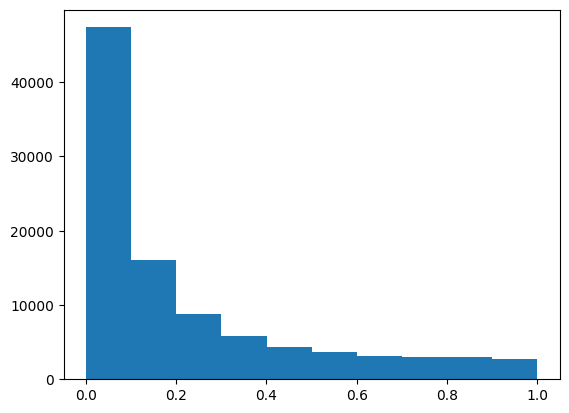

In [ ]:
plt.hist(train_probs[:,1])

In [ ]:
(train_probs[:,1][:20]>0.2).astype(int)

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0])

In [ ]:
(train_probs[:,1][:20]>0.5).astype(int)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0])

In [ ]:
train_probs[:,1].round(2)[:20]
#  >0.2).astype(int)

array([0.06, 0.06, 0.04, 0.01, 0.28, 0.12, 0.06, 0.02, 0.22, 0.04, 0.02,
       0.91, 0.99, 0.36, 0.28, 0.85, 0.09, 0.03, 0.02, 0.08])

In [ ]:
train_targets.value_counts(normalize=True)

,proportion
RainTomorrow,
No,0.777544
Yes,0.222456


Числа вище вказують на ймовірності для цільових класів "Ні" та "Так".

In [ ]:
model.classes_

array(['No', 'Yes'], dtype=object)

Ми можемо перевірити точність прогнозів моделі, обчисливши відсоток співпадаючих значень у `train_preds` та `train_targets`.

Це можна зробити за допомогою функції `accuracy_score` з `sklearn.metrics`.

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(train_targets, train_preds)

0.8519920806629383

Модель досягає точності 85,1% на навчальному наборі. Ми можемо візуалізувати розподіл правильно та неправильно класифікованих входів за допомогою матриці плутанини (confusion matrix).

<img src="https://i.imgur.com/UM28BCN.png" width="480">

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
confusion_matrix(train_targets, train_preds)

array([[72093,  4097],
       [10406, 11392]])

Давайте визначимо допоміжну функцію для генерації прогнозів, обчислення точності та побудови матриці невідповідностей для заданого набору вхідних даних.

In [ ]:
def predict_and_plot(inputs, targets, name=''):
    preds = model.predict(inputs)

    accuracy = accuracy_score(targets, preds)
    print("Accuracy: {:.2f}%".format(accuracy * 100))

    cf = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(cf, annot=True)
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name));

    return preds

Accuracy: 85.20%


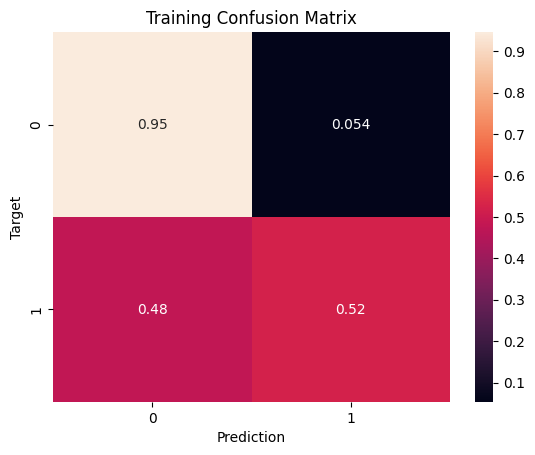

In [ ]:
train_preds = predict_and_plot(X_train, train_targets, 'Training')

Давайте обчислимо точність моделі на валідаційному та тестовому наборах даних також.

Accuracy: 85.39%


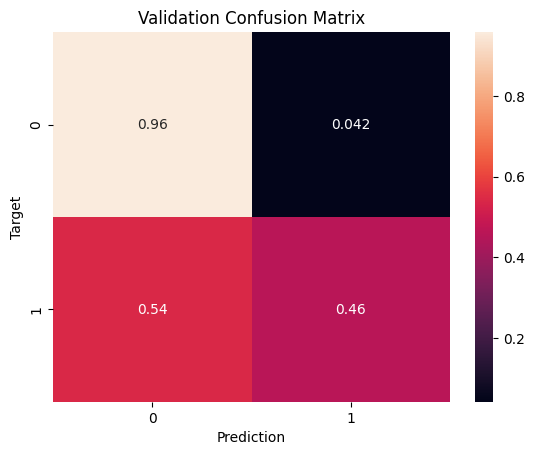

In [ ]:
val_preds = predict_and_plot(X_val, val_targets, 'Validation')

Accuracy: 84.22%


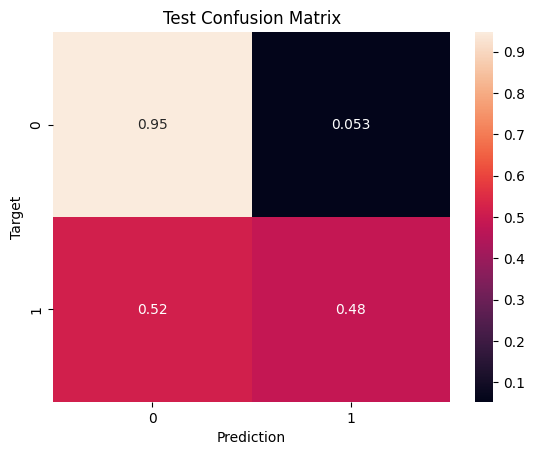

In [ ]:
test_preds = predict_and_plot(X_test, test_targets, 'Test')

Точність моделі на тестовому та валідаційному наборах перевищує 84%, що свідчить про те, що наша модель добре узагальнює дані, які вона раніше не бачила.

Але наскільки хороша точність 84%? Хоча це залежить від природи проблеми та бізнес-вимог, хороший спосіб перевірити, чи модель дійсно навчилася чомусь корисному, — це порівняти її результати з "випадковою" або "дурною" моделлю.

Давайте створимо дві моделі: одну, яка вгадує випадково, і іншу, яка завжди повертає "Ні". Обидві ці моделі повністю ігнорують вхідні дані, які їм надаються.

In [ ]:
def random_guess(inputs):
    return np.random.choice(["No", "Yes"], len(inputs))

In [ ]:
def all_no(inputs):
    return np.full(len(inputs), "No")

Давайте перевіримо точність цих двох моделей на тестовому наборі даних.

In [ ]:
accuracy_score(test_targets, random_guess(X_test))

0.497316219369895

In [ ]:
accuracy_score(test_targets, all_no(X_test))

0.7734344612991054

Наша випадкова модель досягає точності 50%, а наша модель "завжди Ні" досягає точності 77%.

На щастя, наша модель краща за "дурну" або "випадкову" модель! Це не завжди так, тому гарною практикою є порівнювати будь-яку модель, яку ви тренуєте, з такими базовими моделями.

# Precision, Recall, F1-score
Ми з вами помітили, що використання Accuracy метрики не дає нам надто точну оцінку точності моделі, адже для тривіальної моделі, яка завжди каже "Ні" точність дорівнює аж 77%. Ми вже навчились користуватись confusion matrix, але яка ми вже обговорили раніше, в ML-експериментах основна метрика має бути одна. І в задачах бінарної класифікації цією метрикою часто є F1-score. Що ж це за метрика?

F1 метрика поєднує в собі точність (precision) та повноту (recall) для створення єдиного значення, яке балансує між цими двома показниками. Це особливо корисно, коли необхідно оцінити модель за умов незбалансованих даних.

## Визначення
- **Точність (Precision)**: Відсоток правильно передбачених позитивних прикладів серед усіх прикладів, передбачених як позитивні.
  $$
  \text{Precision} = \frac{TP}{TP + FP}
  $$
  де $$ TP $$ (True Positives) — кількість правильно передбачених позитивних випадків, $$ FP $$ (False Positives) — кількість неправильно передбачених позитивних випадків.

- **Повнота (Recall)**: Відсоток правильно передбачених позитивних прикладів серед усіх реальних позитивних прикладів.
  $$
  \text{Recall} = \frac{TP}{TP + FN}
  $$
  де $$ FN $$ (False Negatives) — кількість неправильно передбачених негативних випадків.

## Обчислення F1 метрики
F1 метрика розраховується як гармонічне середнє між точністю та повнотою:
$$
F1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$

## Приклад розрахунку
Розглянемо простий приклад

![](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*ua3zIJ-koDQK6fRageGgFw.png)


In [ ]:
0.66*0.22/(0.66+0.22)

0.165



Отже, F1 метрика для даної моделі становить приблизно 0.165. Це значення вказує на загальну ефективність моделі в умовах, коли ми однаково враховуємо як помилки першого, так і другого роду (false positives та false negatives).

![](https://en.wikipedia.org/wiki/Precision_and_recall)



Більше прикладів і детальніше розібратись можна з цією [статтею](https://towardsdatascience.com/should-i-look-at-precision-recall-or-specificity-sensitivity-3946158aace1).

## Обчислення F1 для нашої моделі




In [ ]:
from sklearn.metrics import f1_score

In [ ]:
preds = model.predict(X_train)
preds[:5], train_targets[:5]

(array(['No', 'No', 'No', 'No', 'No'], dtype=object),
 0    No
 1    No
 2    No
 3    No
 4    No
 Name: RainTomorrow, dtype: object)

In [ ]:
f1_score(train_targets, preds, pos_label='Yes')

0.6110440636146647

In [ ]:
def get_f1_score(inputs, targets, name=''):
  preds = model.predict(inputs)

  f1_score_ = f1_score(targets, preds, pos_label='Yes')
  print(f"F1 score {name}: {f1_score_:.2f}%")

get_f1_score(X_train, train_targets, 'Training')
get_f1_score(X_val, val_targets, 'Validation')
get_f1_score(X_test, test_targets, 'Test')

F1 score Training: 0.61%
F1 score Validation: 0.57%
F1 score Test: 0.58%


## Побудова ROC Curve та обчислення AUROC для нашої моделі


In [ ]:
from sklearn.metrics import roc_curve, auc

def compute_auroc_and_build_roc(inputs, targets, name=''):
  # Predict probabilities
  y_pred_proba = model.predict_proba(inputs)[:, 1]

  # Compute ROC curve
  fpr, tpr, thresholds = roc_curve(targets, y_pred_proba, pos_label='Yes')

    # Compute AUROC
  roc_auc = auc(fpr, tpr)
  print(f'AUROC for {name}: {roc_auc:.2f}')

  # Plot the ROC curve
  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'Receiver Operating Characteristic (ROC) Curve for {name}')
  plt.legend(loc="lower right")
  plt.show()

AUROC for Training: 0.88


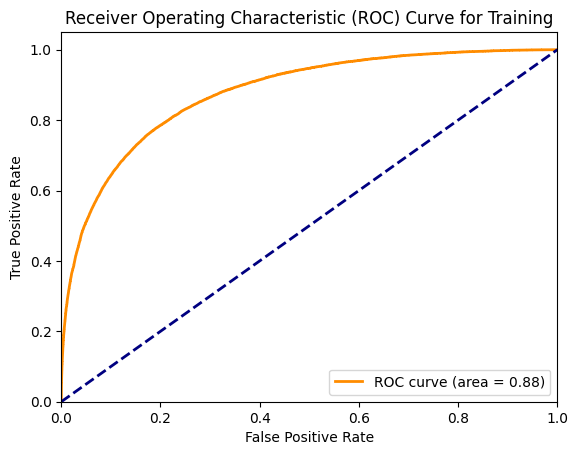

AUROC for Validation: 0.87


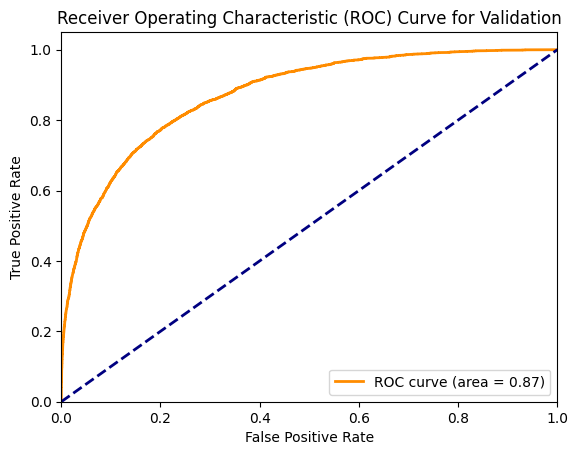

In [ ]:
compute_auroc_and_build_roc(X_train, train_targets, 'Training')
compute_auroc_and_build_roc(X_val, val_targets, 'Validation')

## Прогнозування на основі одного введення

Після того, як модель була навчена до задовільної точності, її можна використовувати для прогнозування нових даних. Розглянемо наступний словник, що містить дані, зібрані сьогодні від метеорологічного департаменту Кетрін.

In [ ]:
new_input = {'Date': '2021-06-19',
             'Location': 'Katherine',
             'MinTemp': 23.2,
             'MaxTemp': 33.2,
             'Rainfall': 10.2,
             'Evaporation': 4.2,
             'Sunshine': np.nan,
             'WindGustDir': 'NNW',
             'WindGustSpeed': 52.0,
             'WindDir9am': 'NW',
             'WindDir3pm': 'NNE',
             'WindSpeed9am': 13.0,
             'WindSpeed3pm': 20.0,
             'Humidity9am': 89.0,
             'Humidity3pm': 58.0,
             'Pressure9am': 1004.8,
             'Pressure3pm': 1001.5,
             'Cloud9am': 8.0,
             'Cloud3pm': 5.0,
             'Temp9am': 25.7,
             'Temp3pm': 33.0,
             'RainToday': 'Yes'}

Перший крок - перетворити словник у Pandas dataframe, подібний до `raw_df`. Це можна зробити, передавши список, що містить даний словник, до конструктора `pd.DataFrame`.

In [ ]:
new_input_df = pd.DataFrame([new_input])

In [ ]:
new_input_df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
0,2021-06-19,Katherine,23.2,33.2,10.2,4.2,NaN,NNW,52.0,NW,NNE,13.0,20.0,89.0,58.0,1004.8,1001.5,8.0,5.0,25.7,33.0,Yes


Ми щойно створили Pandas dataframe з тими ж стовпцями, що й `raw_df` (за винятком `RainTomorrow`, який потрібно передбачити). Dataframe містить лише один рядок даних, що містить заданий вхід.

Тепер ми повинні застосувати ті самі перетворення, які застосовувалися під час навчання моделі:

1. Імпутація відсутніх значень за допомогою раніше створеного `imputer`
2. Масштабування числових ознак за допомогою раніше створеного `scaler`
3. Кодування категоріальних ознак за допомогою раніше створеного `encoder`

In [ ]:
new_input_df[numeric_cols] = imputer.transform(new_input_df[numeric_cols])
new_input_df[numeric_cols] = scaler.transform(new_input_df[numeric_cols])
new_input_df[encoded_cols] = encoder.transform(new_input_df[categorical_cols])

<ipython-input-115-1e64a48fb6dc>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_input_df[encoded_cols] = encoder.transform(new_input_df[categorical_cols])
<ipython-input-115-1e64a48fb6dc>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_input_df[encoded_cols] = encoder.transform(new_input_df[categorical_cols])
<ipython-input-115-1e64a48fb6dc>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 

In [ ]:
X_new_input = new_input_df[numeric_cols + encoded_cols]
X_new_input

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,Location_Adelaide,Location_Albany,Location_Albury,Location_AliceSprings,Location_BadgerysCreek,Location_Ballarat,Location_Bendigo,Location_Brisbane,Location_Cairns,Location_Canberra,Location_Cobar,Location_CoffsHarbour,Location_Dartmoor,Location_Darwin,Location_GoldCoast,Location_Hobart,Location_Katherine,Location_Launceston,Location_Melbourne,Location_MelbourneAirport,Location_Mildura,Location_Moree,Location_MountGambier,Location_MountGinini,Location_Newcastle,Location_Nhil,Location_NorahHead,Location_NorfolkIsland,Location_Nuriootpa,Location_PearceRAAF,Location_Penrith,Location_Perth,Location_PerthAirport,Location_Portland,Location_Richmond,Location_Sale,Location_SalmonGums,Location_Sydney,Location_SydneyAirport,Location_Townsville,Location_Tuggeranong,Location_Uluru,Location_WaggaWagga,Location_Walpole,Location_Watsonia,Location_Williamtown,Location_Witchcliffe,Location_Wollongong,Location_Woomera,WindGustDir_E,WindGustDir_ENE,WindGustDir_ESE,WindGustDir_N,WindGustDir_NE,WindGustDir_NNE,WindGustDir_NNW,WindGustDir_NW,WindGustDir_S,WindGustDir_SE,WindGustDir_SSE,WindGustDir_SSW,WindGustDir_SW,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW,WindGustDir_nan,WindDir9am_E,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW,WindDir9am_nan,WindDir3pm_E,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,WindDir3pm_nan,RainToday_No,RainToday_Yes
0,0.747642,0.714559,0.027493,0.050971,0.532098,0.356589,0.149425,0.229885,0.89,0.58,0.401653,0.371287,0.888889,0.555556,0.685466,0.744141,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Тепер ми можемо зробити прогноз за допомогою `model.predict`.

In [ ]:
prediction = model.predict(X_new_input)[0]

In [ ]:
prediction

'Yes'

Наша модель прогнозує, що завтра в Кетрін буде дощ! Ми також можемо перевірити ймовірність цього прогнозу.

In [ ]:
prob = model.predict_proba(X_new_input)[0]

In [ ]:
prob

array([0.4814147, 0.5185853])

Здається, наша модель не надто впевнена у своєму прогнозі!

Давайте визначимо допоміжну функцію для здійснення прогнозів для окремих вхідних даних.

In [ ]:
def predict_input(single_input):
    input_df = pd.DataFrame([single_input])
    input_df[numeric_cols] = imputer.transform(input_df[numeric_cols])
    input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
    input_df[encoded_cols] = encoder.transform(input_df[categorical_cols])
    X_input = input_df[numeric_cols + encoded_cols]
    pred = model.predict(X_input)[0]
    prob = model.predict_proba(X_input)[0][list(model.classes_).index(pred)]
    return pred, prob

Тепер ми можемо використовувати цю функцію для здійснення прогнозів для окремих вхідних даних.

In [ ]:
new_input = {'Date': '2021-06-19',
             'Location': 'Launceston',
             'MinTemp': 23.2,
             'MaxTemp': 33.2,
             'Rainfall': 10.2,
             'Evaporation': 4.2,
             'Sunshine': np.nan,
             'WindGustDir': 'NNW',
             'WindGustSpeed': 52.0,
             'WindDir9am': 'NW',
             'WindDir3pm': 'NNE',
             'WindSpeed9am': 13.0,
             'WindSpeed3pm': 20.0,
             'Humidity9am': 89.0,
             'Humidity3pm': 58.0,
             'Pressure9am': 1004.8,
             'Pressure3pm': 1001.5,
             'Cloud9am': 8.0,
             'Cloud3pm': 5.0,
             'Temp9am': 25.7,
             'Temp3pm': 33.0,
             'RainToday': 'Yes'}

In [ ]:
predict_input(new_input)

<ipython-input-121-bc00b974dee8>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  input_df[encoded_cols] = encoder.transform(input_df[categorical_cols])
<ipython-input-121-bc00b974dee8>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  input_df[encoded_cols] = encoder.transform(input_df[categorical_cols])
<ipython-input-121-bc00b974dee8>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd

('Yes', 0.6482503149277558)

## Збереження та завантаження навчених моделей

Ми можемо зберегти параметри (ваги та зміщення) нашої навченої моделі на диск, щоб не потрібно було перенавчати модель з нуля кожного разу, коли ми хочемо її використовувати. Разом з моделлю також важливо зберегти імпутери, скейлери, енкодери та навіть назви колонок. Все, що буде необхідно для генерації прогнозів за допомогою моделі, повинно бути збережено.

Ми можемо використовувати модуль `joblib` для збереження та завантаження об'єктів Python на диск.

In [ ]:
import joblib

Спочатку створимо словник, що містить усі необхідні об'єкти.

In [ ]:
aussie_rain = {
    'model': model,
    'imputer': imputer,
    'scaler': scaler,
    'encoder': encoder,
    'input_cols': input_cols,
    'target_col': target_col,
    'numeric_cols': numeric_cols,
    'categorical_cols': categorical_cols,
    'encoded_cols': encoded_cols
}

Тепер ми можемо зберегти це у файл, використовуючи `joblib.dump`

In [ ]:
joblib.dump(aussie_rain, 'aussie_rain.joblib')

['aussie_rain.joblib']

Об'єкт можна завантажити назад за допомогою `joblib.load`

In [ ]:
aussie_rain2 = joblib.load('aussie_rain.joblib')

Давайте використаємо завантажену модель для прогнозування на оригінальному тестовому наборі.

In [ ]:
test_preds2 = aussie_rain2['model'].predict(X_test)
accuracy_score(test_targets, test_preds2)

0.8422014780241152

Як і очікувалося, ми отримуємо той самий результат, що й оригінальна модель.

## Підсумок

Хоча ми розглянули багато матеріалу в цьому уроці, кількість рядків коду для обробки даних і навчання моделі є досить невеликою. Кожен крок вимагає не більше 3-4 рядків коду.

### Попередня обробка даних

In [ ]:
import opendatasets as od
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# Download the dataset
od.download('https://www.kaggle.com/jsphyg/weather-dataset-rattle-package')
raw_df = pd.read_csv('weather-dataset-rattle-package/weatherAUS.csv')
raw_df.dropna(subset=['RainToday', 'RainTomorrow'], inplace=True)

# Create training, validation and test sets
year = pd.to_datetime(raw_df.Date).dt.year
train_df, val_df, test_df = raw_df[year < 2015], raw_df[year == 2015], raw_df[year > 2015]

# Create inputs and targets
input_cols = list(train_df.columns)[1:-1]
target_col = 'RainTomorrow'
train_inputs, train_targets = train_df[input_cols].copy(), train_df[target_col].copy()
val_inputs, val_targets = val_df[input_cols].copy(), val_df[target_col].copy()
test_inputs, test_targets = test_df[input_cols].copy(), test_df[target_col].copy()

# Identify numeric and categorical columns
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()[:-1]
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

# Impute missing numerical values
imputer = SimpleImputer(strategy = 'mean').fit(train_inputs[numeric_cols])
train_inputs[numeric_cols] = imputer.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = imputer.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = imputer.transform(test_inputs[numeric_cols])

# Scale numeric features
scaler = MinMaxScaler().fit(train_inputs[numeric_cols])
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

# One-hot encode categorical features
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(train_inputs[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

# Save processed data to disk
train_inputs.to_parquet('train_inputs.parquet')
val_inputs.to_parquet('val_inputs.parquet')
test_inputs.to_parquet('test_inputs.parquet')
pd.DataFrame(train_targets).to_parquet('train_targets.parquet')
pd.DataFrame(val_targets).to_parquet('val_targets.parquet')
pd.DataFrame(test_targets).to_parquet('test_targets.parquet')

# Load processed data from disk
train_inputs = pd.read_parquet('train_inputs.parquet')
val_inputs = pd.read_parquet('val_inputs.parquet')
test_inputs = pd.read_parquet('test_inputs.parquet')
train_targets = pd.read_parquet('train_targets.parquet')[target_col]
val_targets = pd.read_parquet('val_targets.parquet')[target_col]
test_targets = pd.read_parquet('test_targets.parquet')[target_col]


> **ВПРАВА**: Спробуйте пояснити кожен рядок коду в наведеній вище комірці своїми словами. Прокрутіть назад до відповідних розділів зошита, якщо потрібно.

### Навчання та оцінка моделі

F1 score: 57.03%
F1 score: 58.27%


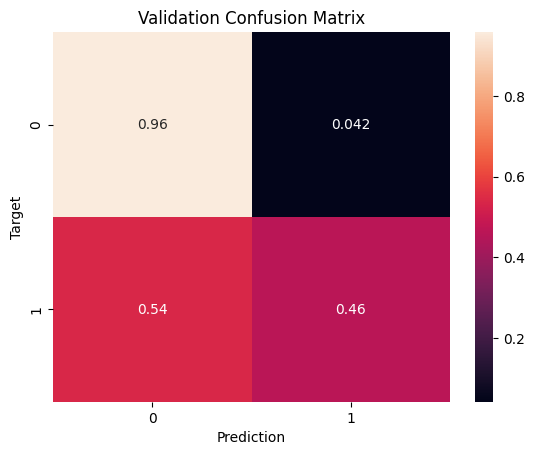

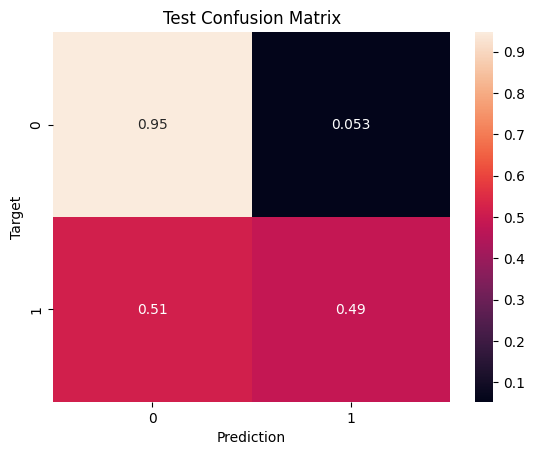

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import joblib

# Select the columns to be used for training/prediction
X_train = train_inputs[numeric_cols + encoded_cols]
X_val = val_inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

# Create and train the model
model = LogisticRegression(solver='liblinear')
model.fit(X_train, train_targets)

# Helper function to predict, compute accuracy & plot confustion matrix
def predict_and_plot(inputs, targets, name=''):
    preds = model.predict(inputs)
    f1 = f1_score(targets, preds, pos_label='Yes')
    print("F1 score: {:.2f}%".format(f1 * 100))
    cf = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(cf, annot=True)
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name));
    return preds

# Evaluate on validation and test set
val_preds = predict_and_plot(X_val, val_targets, 'Validation')
test_preds = predict_and_plot(X_test, test_targets, 'Test')

# Save the trained model & load it back
aussie_rain = {'model': model, 'imputer': imputer, 'scaler': scaler, 'encoder': encoder,
               'input_cols': input_cols, 'target_col': target_col, 'numeric_cols': numeric_cols,
               'categorical_cols': categorical_cols, 'encoded_cols': encoded_cols}
joblib.dump(aussie_rain, 'aussie_rain.joblib')
aussie_rain2 = joblib.load('aussie_rain.joblib')

> **ВПРАВА**: Спробуйте пояснити кожен рядок коду в наведеній вище комірці своїми словами. Прокрутіть назад до відповідних розділів зошита, якщо потрібно.

### Прогнозування на окремих вхідних даних

In [ ]:
def predict_input(single_input):
    input_df = pd.DataFrame([single_input])
    input_df[numeric_cols] = imputer.transform(input_df[numeric_cols])
    input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
    input_df[encoded_cols] = encoder.transform(input_df[categorical_cols])
    X_input = input_df[numeric_cols + encoded_cols]
    pred = model.predict(X_input)[0]
    prob = model.predict_proba(X_input)[0][list(model.classes_).index(pred)]
    return pred, prob

new_input = {'Date': '2021-06-19',
             'Location': 'Launceston',
             'MinTemp': 23.2,
             'MaxTemp': 33.2,
             'Rainfall': 10.2,
             'Evaporation': 4.2,
             'Sunshine': np.nan,
             'WindGustDir': 'NNW',
             'WindGustSpeed': 52.0,
             'WindDir9am': 'NW',
             'WindDir3pm': 'NNE',
             'WindSpeed9am': 13.0,
             'WindSpeed3pm': 20.0,
             'Humidity9am': 89.0,
             'Humidity3pm': 58.0,
             'Pressure9am': 1004.8,
             'Pressure3pm': 1001.5,
             'Cloud9am': 8.0,
             'Cloud3pm': 5.0,
             'Temp9am': 25.7,
             'Temp3pm': 33.0,
             'RainToday': 'Yes'}

predict_input(new_input)

<ipython-input-128-3cf2bb9907bf>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  input_df[encoded_cols] = encoder.transform(input_df[categorical_cols])
<ipython-input-128-3cf2bb9907bf>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  input_df[encoded_cols] = encoder.transform(input_df[categorical_cols])
<ipython-input-128-3cf2bb9907bf>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd

('Yes', 0.632089929547187)


# Пайплайни
В цій роботі ми для тренування моделі пройшли кілька кроків попередньої обробки даних: заповнення пропущених значень, масштабування числових ознак, кодування категоріальних ознак. Після кожного кроку в нас створюються нові структури даних і ми маємо їх записати. Також в якийсь момент ми можемо припуститись помилки і забути запустити якисьй крок.

Тому для багатоетапної попередньої обробки даних часто використовують паймплайни - `sklearn piplines`. І це дуже зручно, та значно зменшує кількість коду.

### Що таке пайплайни в `sklearn`?

Пайплайни в `sklearn` є потужним інструментом, який допомагає об'єднати кілька кроків обробки даних та навчання моделі в один цілісний об'єкт. Це дозволяє спростити та автоматизувати робочий процес машинного навчання, забезпечуючи:

1. **Управління послідовністю кроків**: Всі етапи обробки та навчання можуть бути визначені та виконані в певному порядку.
2. **Уніфікований інтерфейс**: Пайплайни надають єдиний інтерфейс для налаштування параметрів, навчання та оцінки моделі.
3. **Зменшення ризику витоку даних**: Пайплайни дозволяють правильно розділяти обробку даних та навчання моделі, зменшуючи ризик витоку даних між тренувальними та тестовими наборами.

### Простий приклад пайплайна

Розглянемо простий приклад створення пайплайна для задачі бінарної класифікації з використанням стандартного набору даних `breast_cancer` з `sklearn`. Цей набір даних містить різні характеристики клітин та інформацію про те, чи є вони злоякісними або доброякісними.


In [ ]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

# Завантажуємо дані
data = load_breast_cancer()
X, y = data.data, data.target

# Розділяємо дані на тренувальний та тестовий набори
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Створюємо пайплайн
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Масштабування даних
    ('classifier', LogisticRegression())  # Логістична регресія
])

# Навчаємо модель
pipeline.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', LogisticRegression())])

In [ ]:
pipeline.named_steps['scaler'].transform(X_test)

array([[-0.46649743, -0.13728933, -0.44421138, ..., -0.19435087,
         0.17275669,  0.20372995],
       [ 1.36536344,  0.49866473,  1.30551088, ...,  0.99177862,
        -0.561211  , -1.00838949],
       [ 0.38006578,  0.06921974,  0.40410139, ...,  0.57035018,
        -0.10783139, -0.20629287],
       ...,
       [-0.73547237, -0.99852603, -0.74138839, ..., -0.27741059,
        -0.3820785 , -0.32408328],
       [ 0.02898271,  2.0334026 ,  0.0274851 , ..., -0.49027026,
        -1.60905688, -0.33137507],
       [ 1.87216885,  2.80077153,  1.80354992, ...,  0.7925579 ,
        -0.05868885, -0.09467243]])

In [ ]:
# Робимо прогнози
y_pred = pipeline.predict(X_test)

# Оцінюємо модель
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1:.2f}')

# Виводимо звіт про класифікацію
print(classification_report(y_test, y_pred, target_names=data.target_names))

F1 Score: 0.98
              precision    recall  f1-score   support

   malignant       0.98      0.95      0.96        43
      benign       0.97      0.99      0.98        71

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



**Пайплайни - це зручно!**

Нижче показую, як ми можемо нашу розробку зібрати у пайплайн.

F1 score: 0.57%


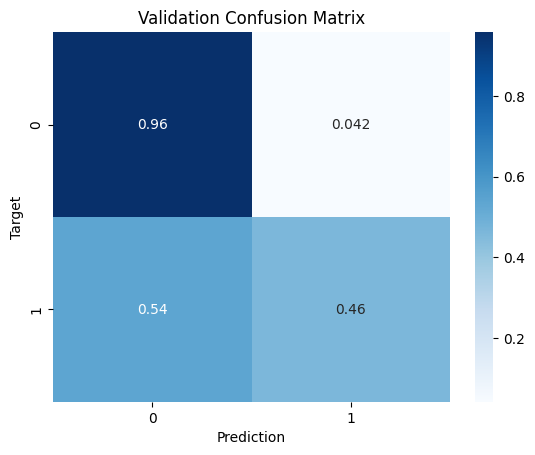

F1 score: 0.58%


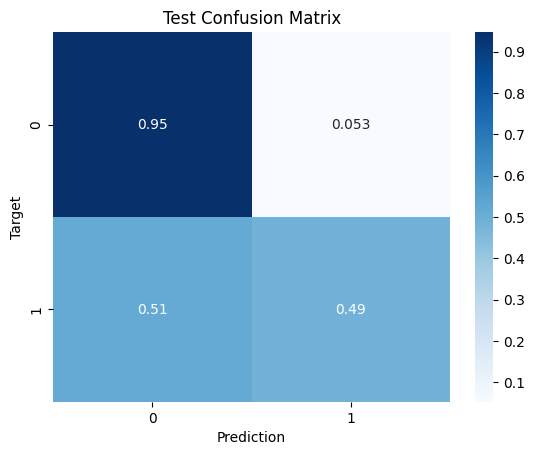

In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Download the dataset
od.download('https://www.kaggle.com/jsphyg/weather-dataset-rattle-package')
raw_df = pd.read_csv('weather-dataset-rattle-package/weatherAUS.csv')
raw_df.dropna(subset=['RainToday', 'RainTomorrow'], inplace=True)

# Create training, validation and test sets
year = pd.to_datetime(raw_df.Date).dt.year
train_df, val_df, test_df = raw_df[year < 2015], raw_df[year == 2015], raw_df[year > 2015]

# Create inputs and targets
input_cols = list(train_df.columns)[1:-1]
target_col = 'RainTomorrow'
train_inputs, train_targets = train_df[input_cols], train_df[target_col]
val_inputs, val_targets = val_df[input_cols], val_df[target_col]
test_inputs, test_targets = test_df[input_cols], test_df[target_col]

# Identify numeric and categorical columns
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()[:-1]
categorical_cols = train_inputs.select_dtypes(include='object').columns.tolist()

# Create preprocessing pipelines for both numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Combine transformers into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Create a pipeline that includes preprocessing and the model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# Train the model
model_pipeline.fit(train_inputs, train_targets)

# Helper function to predict, compute accuracy & plot confusion matrix
def predict_and_plot(inputs, targets, name=''):
    preds = model_pipeline.predict(inputs)
    f1 = f1_score(targets, preds, pos_label='Yes')
    print("F1 score: {:.2f}%".format(f1))
    cf = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(cf, annot=True, cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()
    return preds

# Evaluate on validation and test set
val_preds = predict_and_plot(val_inputs, val_targets, 'Validation')
test_preds = predict_and_plot(test_inputs, test_targets, 'Test')

# Save the trained model
joblib.dump(model_pipeline, 'aussie_rain_pipeline.joblib')

# Load the trained model
model_pipeline_loaded = joblib.load('aussie_rain_pipeline.joblib')
